# Movie Genre Predictor

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/chrispyles/jupyter/master?filepath=content%2Fnotebooks%2Fmovies%2Fmovies.ipynb)

In this Jupyter Notebook, I will build a $k$-nearest neighbors classifier that will determine the genre of a movie based on its synopsis. The [Wikipedia Movie Plots data set](https://www.kaggle.com/jrobischon/wikipedia-movie-plots) is used in order to generate the training set for the classifier, and I will build my own test set from [IMDB](https://imdb.com). The classifier will work by looking at the frequencies of words in the synposes of movies from each genre.

1. [The Question](#question)
2. [Data Preprocessing](#preprocessing)
3. [Grouping Plots & Word Recurrence](#grouping)

In [1]:
import numpy as np
import pandas as pd
import string
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# read table
movies = pd.read_csv('movie_plots.csv')
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


<div id="question"></div>

## The Question 
The first part of developing a data-driven project is to decide what question you want to answer. The question needs to be specific, and it needs to be something you can develop a step-by-step approach for. With this notebook, I am going to use the `movies` DataFrame to answer the following question:
> Can we predict the genre of a movie based on its plot?

It will take a few steps to answer this question. The over-arching workflow will look something like this:
1. Data preprocessing
2. Group movies by genre and look for recurring words in plots
3. Write a $k$-nearest neighbor classifier
4. Test the classifier and determine its accuracy

<div id="preprocessing"></div>

## Data Preprocessing
Currently, the `movies` DataFrame contains details of movies (year, title, country of origin, director, cast, genre, Wiki link, and plot). In order to get meaningful results, the data need to be "cleaned;" that is, we need to edit values that we can't work with. ince we're focusing on the genre and plot, we can remove columns with irrelevant information:

In [2]:
movies = movies[['Genre', 'Plot']]
movies.head()

,Genre,Plot
0,unknown,"A bartender is working at a saloon, serving dr..."
1,unknown,"The moon, painted with a smiling face hangs ov..."
2,unknown,"The film, just over a minute long, is composed..."
3,unknown,Lasting just 61 seconds and consisting of two ...
4,unknown,The earliest known adaptation of the classic f...


The data set, which contains 34,885 entries, has lots of rows that contain `NaN` values ("not a number"), which means that we can't work with them. The `pandas` library allows you to remove the rows that contain `NaN` values:

In [3]:
movies = movies.dropna().reset_index(drop=True)
print(f"There are now {movies.shape[0]} rows in the table.")
movies.head()

There are now 34886 rows in the table.


,Genre,Plot
0,unknown,"A bartender is working at a saloon, serving dr..."
1,unknown,"The moon, painted with a smiling face hangs ov..."
2,unknown,"The film, just over a minute long, is composed..."
3,unknown,Lasting just 61 seconds and consisting of two ...
4,unknown,The earliest known adaptation of the classic f...


In the above cell, we also reset the row indices to make slicing the table easier. We now have 34,886 rows, so we lost about 1,400 entries. The next thing to look at is what kinds of values we have in the DataFrame.

#### Data Exploration and Accptable Genres
Now we need to see what kinds of data we have in the set. We begin by showing what the values in the `Genre` column of the DataFrame are:

In [4]:
movies['Genre'].unique()

array(['unknown', 'western', 'comedy', ...,
       'adventure, romance, fantasy film', 'ero',
       'horror romantic comedy'], dtype=object)

It looks like there's lots of different values in the column (2,210 to be exact). But for this question, we're really only interested in the basic genres of movies: action, adventure, comedy, drama, fantasy, historical, horror, romance, science fiction, and thriller.

To this end, we will define a function that will read through the `Genre` entry in each row and categorize them as one of the above. This process has a few steps:
1. Define a function that will determine if any of the above words are present in the entry
2. Filter `movies` for such rows
3. Change the entry for `Genre` to one of the above for each row left if entry is not one of the above

In [5]:
# Step 1:
def contains_acceptable_genre(entry):
    acceptable_genres = ['action', 'adventure', 'comedy', 'drama', 'fantasy', 'historical', 'horror', 
                        'romance', 'science fiction', 'thriller']
    for genre in acceptable_genres:
        if genre in entry['Genre']:
            return True
    return False

# Step 2:
filtered_movies = movies[movies.apply(contains_acceptable_genre, axis=1)].reset_index(drop=True)
filtered_movies.head()

,Genre,Plot
0,comedy,The film is about a family who move to the sub...
1,short action/crime western,The film features a train traveling through th...
2,comedy,Before heading out to a baseball game at a nea...
3,comedy,The plot is that of a black woman going to the...
4,drama,On a beautiful summer day a father and mother ...


In order to accomplish Step 3, we need to develop a few helper functions. Mainly, we need to comb each `Genre` entry in `filtered_movies` do the following:
1. Check if it is an exact match for something in `acceptable_genres`
2. If it is not, then use a heuristic to determine which genre it is a part of
3. Apply this function to each row of the DataFrame

For Step 3.1, we define the function `superfluous_text` which returns a Boolean value corresponding to whether or not there are extra characters beyond an entry in `accaptable_genres`.

In [6]:
# Step 3.1:
def superfluous_text(entry):
    """
    Determines if the string entry is in acceptable_genres
    """
    acceptable_genres = ['action', 'adventure', 'comedy', 'drama', 'fantasy', 'historical', 'horror', 
                        'romance', 'science fiction', 'thriller']
    for genre in acceptable_genres:
        if genre == entry:
            return False
    return True

For Step 3.2, we take entries for which `superfluous_text` returns `True` and use a heuristic to determine which is the most accurate genre they fall under. The heuristic that we use is that the last word is likely the most general genre (i.e. the noun without any modifiers). In this way, `'historical drama'` would become `'drama'` and `'action comedy'` would become `'comedy'`.

The function `determine_genre` looks for words starting from the last word and going to the first until it finds an entry in `acceptable_genres`. If no such word exists, then an empty string, `''`, is inserted instead.

In [7]:
# Step 3.2:
def determine_genre(entry):
    """
    Takes a string entry and returns the word closest to the end that is in acceptable_genres
    """
    acceptable_genres = ['action', 'adventure', 'comedy', 'drama', 'fantasy', 'historical', 'horror', 
                        'romance', 'science fiction', 'thriller']

    if not superfluous_text(entry):
        return entry
    for c in entry:
        if c not in string.ascii_lowercase:
            genre = entry.replace(c, '')
    try:
        genre = genre.split(' ')
    except UnboundLocalError:
        genre = entry.split(' ')

    i = -1
    new_genre = ''
    while new_genre not in acceptable_genres:
        try:
            new_genre = genre[i]
        except IndexError:
            new_genre = ''
            return new_genre
        if genre not in acceptable_genres:
            i -= 1

    return new_genre

Finally, for Step 3.3, the function `change_genres` takes a DataFrame as its argument and goes through the `Genre` column to replace the original `Genre` with the result of `determine_genre`. Then a new DataFrame is generated by copying the one passed as the argument and dropping the original `Genre` column and replacing it with a new `Genre` column. Then it filters out rows where the empty string `''` was inserted instead of a genre.

In [8]:
# Step 3.3:
def change_genres(df):
    new_genres = np.array([])
    for entry in df['Genre']:
        new_genre = determine_genre(entry)
        new_genres = np.append(new_genres, new_genre)
    
    new_df = df.drop(columns=['Genre']).assign(Genre=new_genres)
    new_df = new_df[new_df['Genre'] != ''].reset_index(drop=True)
    
    return new_df

filtered_genres = change_genres(filtered_movies)
print(f"The table now has {filtered_genres.shape[0]} rows.")
filtered_genres.head()

The table now has 15852 rows.


,Plot,Genre
0,The film is about a family who move to the sub...,comedy
1,Before heading out to a baseball game at a nea...,comedy
2,The plot is that of a black woman going to the...,comedy
3,On a beautiful summer day a father and mother ...,drama
4,A thug accosts a girl as she leaves her workpl...,drama


#### Cleaning Plot Strings
Now that we have sorted the genres of each movie in the DataFrame, we look now to format the `Plot` column so that it can be more easily analyzed. In the cell below, the function `clean_string` is defined, which removes all characters that are not letters from a string and makes all letters lowercase. Then the function `words_in_dict` is defined which takes in a string and returns a string containing words in the file [dict.csv](#dict). Finally, `clean_plots` is defined, which takes a DataFrame as its parameter and goes through each `Plot` entry and cleans the string there, returning a new DataFrame with cleaned plot strings.

Because the function `clean_plots` takes a while to run on the data set, I ran it once and then exported it as `movies_with_cleaned_plots.csv`. The commented out code at the bottom of the cell shows how the function was run and exported. Instead of running it again, we just import the cleaned data using `pd.read_csv()`.

In [11]:
dictionary = list(pd.read_csv('dict.csv')['dictionary'])

def clean_string(s):
    for c in s:
        if c not in string.ascii_letters + ' ':
            s = s.replace(c, '')
        elif c in string.ascii_uppercase:
            i = string.ascii_uppercase.index(c)
            s = s.replace(c, string.ascii_lowercase[i])
            
    return s

def words_in_dict(s):
    s = s.split(' ')
    
    words_to_delete = []
    for word in s:
        if word not in dictionary:
            words_to_delete += [word]
            
    for word in words_to_delete:
        s.remove(word)
        
    return ' '.join(s)

def clean_plots(df):
    plots = list(df['Plot'])
    
    cleaned_plots = []
    for plot in plots:
        cleaned_plot = clean_string(plot)
        cleaned_plot = words_in_dict(cleaned_plot)
        cleaned_plots += [cleaned_plot]
        
    new_df = df.drop(['Plot'], axis=1).assign(Plot=cleaned_plots)
    return new_df

# # Commented out below lines to save time when running this code later:
# movies_with_cleaned_plots = clean_plots(filtered_genres)
# movies_with_cleaned_plots.to_csv('movies_with_cleaned_plots.csv', index=False)

# Importing the csv with the data that would have been created by running the code above:
movies_with_cleaned_plots = pd.read_csv('movies_with_cleaned_plots.csv')
movies_with_cleaned_plots.head()

,Genre,Plot
0,comedy,film about a family hoping for a life go leadi...
1,comedy,heading a game a fan he watch game has game hi...
2,comedy,a going for a given laughing gas her walking h...
3,drama,a a father take river a wares gypsy rob father...
4,drama,a a girl leaves her a her revenge help girl he...


<div id="grouping"></div>

## Grouping Plots & Word Recurrence
Before going on, I think it's a good idea to see how prevalent the different genres are in our classifier. To that end, I will plot a histogram of this data using matplotlib.

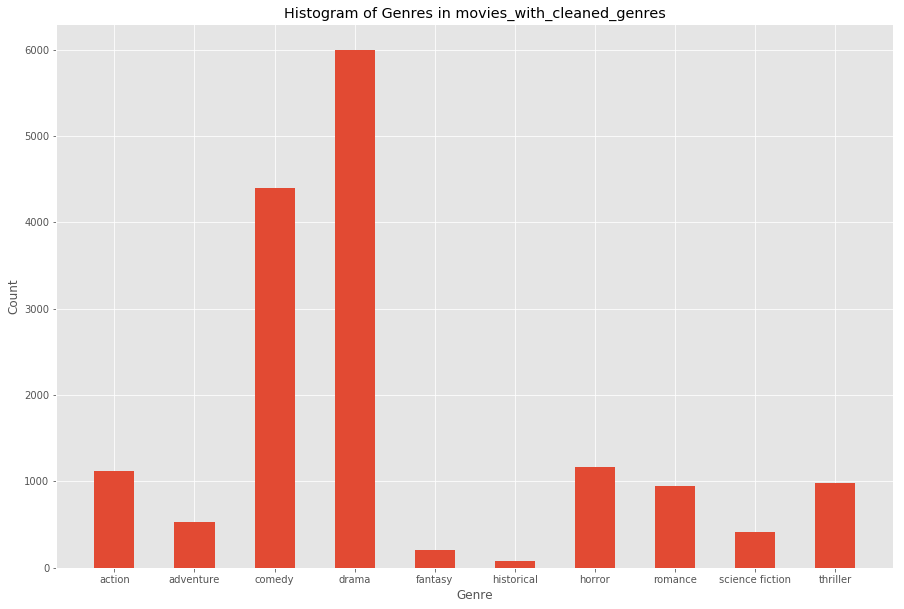

In [18]:
genre_counts = movies_with_cleaned_plots.groupby('Genre').count()

plt.figure(figsize=[15,10])
plt.bar(genre_counts.index.values, genre_counts['Plot'], width=0.5)
plt.title('Histogram of Genres in movies_with_cleaned_genres')
plt.xlabel('Genre')
plt.ylabel('Count');

Obviously, there is a wide variance of the frequency of each genre. This will likely affect the accuracy of the classifier, but we will test that in the last section of this notebook.

Now we can begin look at recurrent words within genres. To begin, we group the `movies_with_cleaned_plots` table by genre and aggregate the `Plot` column into lists.

In [23]:
plot_lists = movies_with_cleaned_plots.groupby('Genre').agg(list)
plot_lists.head()

,Plot
Genre,
action,[in world war i american pilots mal andrews ch...
adventure,[a white girl florence lawrence rejects a prop...
comedy,[before heading out to a baseball game at a ne...
drama,[on a beautiful summer day a father and mother...
fantasy,[the daughter of king neptune takes on human f...


In [29]:
words_by_genre = {}
for genre in plot_lists.index.values:
    plots = plot_lists.loc[genre,].values[0]
    
    word_counts = {}
    for plot in plots:
        plot = plot.split(' ')
        for word in plot:
            try:
                word_counts[word] += 1
            except KeyError:
                word_counts[word] = 1
    words_by_genre[genre] = word_counts

## Notes

<div id="dict"></div>

`dict.csv`: This CSV file contains (almost) all the words in the English language, transformed to lowercase and with any punctuation removed. The file is from [this Github repo](https://github.com/manassharma07/English-Dictionary-CSV), and it exists in its original format in the file [dictionary.csv](./dictionary.csv). To see the code that I used to transform the dictionary to lower case and remove punctuation, see [editing_dictionary.ipynb](./editing_dictionary).